<a href="https://colab.research.google.com/github/AndrewTShen/pytorch-explorations/blob/master/loss_and_gradient_examples2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loss and Gradient Examples

## Introduction
This notebook contains two examples that demonstrate how loss and gradient functions work in PyTorch. We cover numerous topics from writing our own custom loss function to working in higher dimensions. We will solve not necessary classification problems, but interesting problems that can take advantage of PyTorch's tensors and autograd capabilities.

## Table of Contents
[1.](#example-1-parabola-minimum) In this example, we write a simple loss function and try to minimize a parabola. \
***Key ideas***: *Defining a custom loss function*

[2.](#example-2-shortest-path-problem) In this example, we initialize N points and try to find the shortest path from (0, 0) to (100, 100). This uses slightly more complex function, but in terms of training is roughly the same. \
***Key ideas***: *Working with higher dimensions*

[3.](#example-3-shortest-path-problem-with-a-twist) In this example, we continue the shortest path problem from before, however, we add a new twist: the all of the points along our gradient descent must lie along a circle. \
***Key ideas***: *Parameterizing our functions*


## Notes
- This notebook is run with Google Colab's provided TPU.
- Each example includes the required 

## Imports and Cuda/TPU Setup

In [0]:
# Required Imports for Examples
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
# use_cuda = True # If cuda is unavaliable, comment out.
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

<a id='example-1-parabola-minimum'></a>
## Example 1 Parabola Minimum

### Introduction
In this section, we use PyTorch to perform gradient descent on a parabola function (defined by squared) in order to find the minimum point on the parabola

### Defining a Custom Loss Function
Defining a custom loss function in PyTorch is as simple as returning a tensor that contains the loss that you wish to use. Autograd will automatically try to reduce the loss produced in your function. As a side note, one thing you might want to be careful about while writing your own custom loss function is to avoid creating any new tensors from `torch.Tensor`, which actually detaches and copies the data causing you to need to reenable `autograd`. You should not need to reenable `requires autograd` on any new tensors in your loss  function.


In [0]:
# Our parabola function
def squared(x):
  return torch.pow(x, 2)

Start x:  224.61318969726562
Final x:  8.407790785948902e-45


Text(0, 0.5, 'Loss')

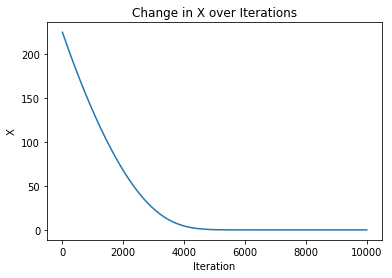

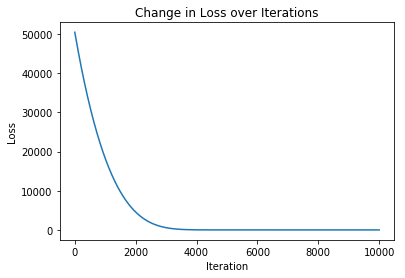

In [0]:
# generate starting point
x = (200) * torch.rand(1) + 100
x.requires_grad_()

start = x.data[0].item()

# create Adam optimizer
optimizer = optim.Adam([x], lr=0.1)

# for use in graph
data = []
data_loss = []

# training
for i in range(10000):
  loss = squared(x)
  data_loss.append(loss)
  loss.backward()
  optimizer.step()    # Does the update
  optimizer.zero_grad()
  data.append(x.data[0].item())

final = x.data[0].item()

print("Start x: ", start)
print("Final x: ", final)

# Plot all data
plt.figure(1)
plt.title("Change in X over Iterations")
plt.plot(data)
plt.xlabel("Iteration")
plt.ylabel("X")

plt.figure(2)
plt.title("Change in Loss over Iterations")
plt.plot(data_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")

<a id="example-2-shortest-path-problem"></a>
## Example 2 Shortest Path Problem


### Introduction
In this section, we use PyTorch to find a N intermediate and equally spaced points between a start and final point which is along the shortest path from the start and final point. We will use the points (0, 0, 0) and (100, 100, 100) as our starting and final points respective for simplicity, but these can easily be adjusted.

### Dimensions
In this example we use 3d points in order to demonstrate the shortest path minimization, however it can easily be adjusted to N dimensions by adding more dimensions on to the tensors and changing the torch distance function (found in the loss section) to use p=N in order to take distance in that dimension.

### Visualization of Change
In general, data in lower dimensions is far easier to visualize and using matplotlib offers a good tool to graph the data and show the change in the individual values of the points as well as the loss value.

In [0]:
# Loss Function
def Loss_length(inp):
  path = torch.cat( (torch.tensor([[0.,0., 0.]]), inp, torch.tensor([[100., 100., 100.]])), 0)  
  # inp is a tensor of size (n, 2)
  return torch.stack([torch.dist(path[i+1], path[i], p = 3) + 100./torch.dist(path[i+1], path[i], p = 3) for i in range(path.shape[0]-1)]).sum(dim=0)

Start x:  [[-103.854675    29.267075    -2.9042816]
 [-133.16357    -36.541336  -213.1458   ]
 [-135.02438   -121.26244     28.528305 ]
 [ 145.00755    183.50238    -35.981724 ]
 [-312.42987     26.83593     10.405041 ]]
Final x:  [[16.666668 16.666613 16.666668]
 [33.333206 33.333504 33.333336]
 [50.       49.999992 50.      ]
 [66.666664 66.666664 66.66664 ]
 [83.33333  83.33333  83.33337 ]]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


[]

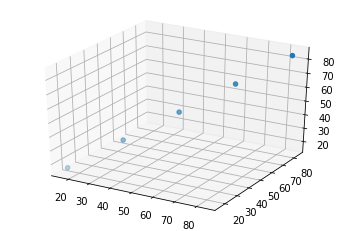

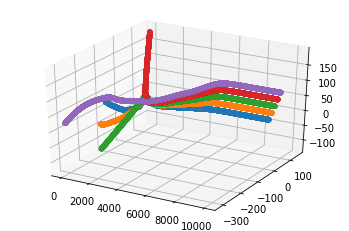

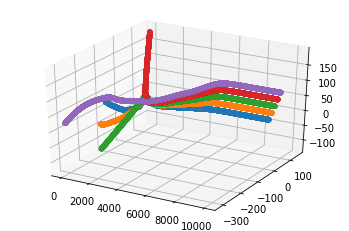

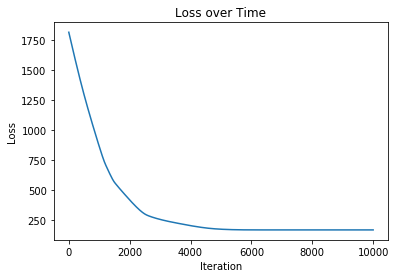

In [0]:
# generate starting points
x = (100) * torch.randn(5, 3) - 50
x.requires_grad_()

# set number of iteration
num_iterations = 10000

start = x.data.cpu().numpy().copy()

# create Adam optimizer
optimizer = optim.Adam([x], lr=0.1)

# for use in graph
data = []
data_loss = []

# training
for i in range(num_iterations):
  loss = Loss_length(x)
  data_loss.append(loss)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  data.append(x.cpu().data.numpy().copy())

final = x.data.cpu().numpy().copy()

# Print starting points and ending points.
print("Start x: ", start)
print("Final x: ", final)

data = np.array(data)

# Plot all data

# Figure 0: Demonstrate convergence to linear
fig = plt.figure(0)
plt.title("Demonstrate Convergence to Linear")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final[:,0], final[:,1], final[:,2])

# Show change over time in 3d, works with 2d data, 3d gets messy
fig = plt.figure(1)
plt.title("Change over Time (3d view)")
ax = fig.add_subplot(111, projection='3d')
for i in range(5):
  ax.scatter(np.arange(num_iterations), data[:, i, 0], data[:, i, 1])
  
# Show change over time in 2d (Flattened view)
fig = plt.figure(2)
plt.title("Change over Time (2d view)")
ax = fig.add_subplot(111, projection='3d')
for i in range(5):
  ax.scatter(np.arange(num_iterations), data[:, i, 0], data[:, i, 1])

# Loss over time
plt.figure(3)
plt.title("Loss over Time")
plt.plot(data_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot()

<a id="example-3-shortest-path-problem-with-a-twist"></a>
## Example 3 Shortest Path Problem With A Twist

### Introduction
In this section, we introduce the idea of using parameters to allow us to be more expressive with our gradient descent. In our case, by using our variable `x` as a parameter for a parameterized function, we can decent in along the arc of a circle. This can be be particularly useful when trying to model more complex functions.

In [0]:
# Loss Function
def Loss_length(inp):
  path = torch.cat( (torch.tensor([[-1.,-1.]]), inp, torch.tensor([[1., 1.]])), 0)  
  # inp is a tensor of size (n, 2)
  return torch.stack([torch.dist(path[i+1], path[i], p = 2) for i in range(path.shape[0]-1)]).sum(dim=0)

# Circle Parameter
def point_to_coord(t):
  return torch.stack([torch.cos(t), torch.sin(t)])

def list_to_coords(inp):
  return torch.stack([point_to_coord(inp[i]) for i in range(inp.shape[0])])


torch.Size([5])
Start x:  [[-0.20116526  0.97955734]
 [ 0.34106955 -0.9400381 ]
 [-0.9941566   0.10794728]
 [ 0.89038223  0.45521364]
 [-0.9874387   0.1580028 ]]
Final x:  [[-0.70705205 -0.70716155]
 [-0.70726377 -0.7069498 ]
 [-0.7065486  -0.70766455]
 [ 0.7065697   0.70764345]
 [ 0.70758504  0.7066282 ]]


[]

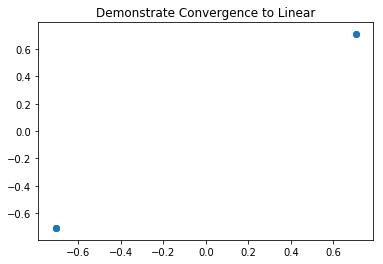

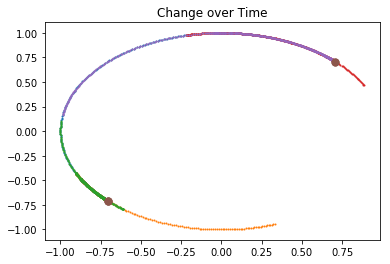

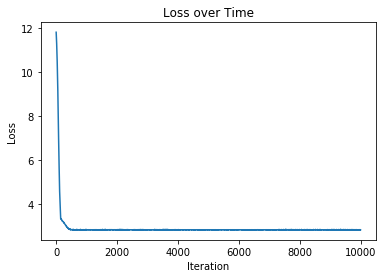

In [0]:
# generate starting values for t, our parameter
x = 2 * np.pi * torch.rand(5)
x.requires_grad_()

# set number of iteration
num_iterations = 10000

start = list_to_coords(x).data.cpu().numpy().copy()

# create Adam optimizer
optimizer = optim.Adam([x], lr=0.01)

# for use in graph
data = []
data_loss = []

# training
for i in range(num_iterations):
  loss = Loss_length(list_to_coords(x))
  data_loss.append(loss)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  data.append(list_to_coords(x).cpu().data.numpy().copy())

final = list_to_coords(x).data.cpu().numpy().copy()

# Print starting points and ending points.
print("Start x: ", start)
print("Final x: ", final)

data = np.array(data)

# Plot all data
#--------------
# Demonstrate convergence to linear
plt.figure(1)
plt.title("Demonstrate Convergence to Linear")
plt.scatter(final[:,0], final[:,1])

# Show change over time # works with 2d data, 3d gets messy
plt.figure(2)
plt.title("Change over Time")
for i in range(5):
  plt.scatter(data[:, i, 0], data[:, i, 1], s=1)
# Ending point extra bold
plt.scatter(final[:,0], final[:,1], s=50)

# Loss over time
plt.figure(3)
plt.title("Loss over Time")
plt.plot(data_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot()


## Example 4 Shortest Path 

### Introduction

In [0]:
# Loss Function
def Loss_length(inp):
  start = torch.tensor([[1.,0.,0.]])
  end = torch.tensor([[-1.,0.,0.,]])
  path = torch.cat((start, inp, end), 0)  
  # inp is a tensor of size (n, 3)
  # motivations behind this formula,
  # trivial loss on distance, but additional lost on the size of the segment.
  num_paths = path.shape[0]-1
#   return torch.stack([torch.dist(path[i+1], path[i], p = 3) + torch.pow(torch.dist(path[i+1], path[i], p = 3)-(spherical_dist(start[0], end[0])/num_paths), 2) for i in range(num_paths)]).sum(dim=0)
  return torch.stack([torch.dist(path[i+1], path[i], p = 3) + 1./torch.dist(path[i+1], path[i], p = 3) for i in range(num_paths)]).sum(dim=0)

def spherical_angle(p1, p2):
  return torch.acos(torch.dot(p1, p2)/ (torch.norm(p1) * torch.norm(p2)))

def spherical_dist(p1, p2, r=1):
  return spherical_angle(p1, p2) * r

def Loss_no_penalty(inp):
  start = torch.tensor([[1.,0.,0.]])
  end = torch.tensor([[-1.,0.,0.,]])
  path = torch.cat((start, inp, end), 0)  
  num_paths = path.shape[0]-1
  return torch.stack([torch.dist(path[i+1], path[i], p = 3) for i in range(num_paths)]).sum(dim=0)

# Circle Parameter
def point_to_coord(t, s):
  return torch.stack([torch.cos(t) * torch.cos(s), torch.cos(t) * torch.sin(s), torch.sin(t)])

def list_to_coords(inp):
  return torch.stack([point_to_coord(inp[0][i], inp[0][i]) for i in range(inp.shape[1])])

# print(spherical_dist(torch.tensor([1.,0.,0.]), torch.tensor([-1.,0.,0.])))

Start x:  [[0.796 -0.403 0.451]
 [0.889 0.314 0.334]
 [0.931 -0.253 -0.262]
 [0.885 -0.319 -0.339]
 [0.182 0.386 -0.904]]
Final x:  [[0.362 -0.481 0.799]
 [0.234 0.423 0.875]
 [0.980 0.141 0.143]
 [0.420 -0.493 -0.762]
 [0.162 0.369 -0.915]]
Final Loss:  tensor(12.1229, grad_fn=<SumBackward2>)
Final Loss (no penalty):  tensor(6.0654, grad_fn=<SumBackward2>)


[]

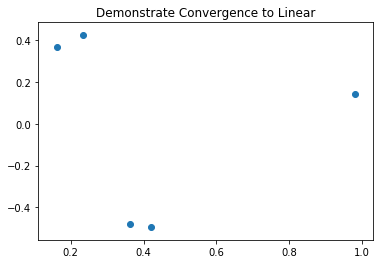

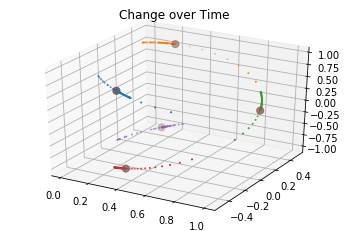

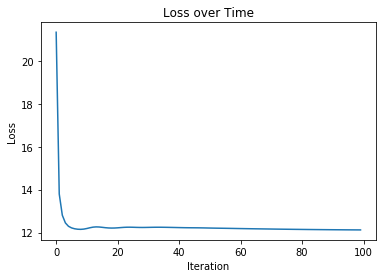

In [45]:
# generate starting values for t, our parameter
x = torch.stack([2 * np.pi * torch.rand(5), np.pi * torch.rand(5) - np.pi/2])
x.requires_grad_()

# set number of iteration
num_iterations = 100

start = list_to_coords(x).data.cpu().numpy().copy()

# create Adam optimizer
optimizer = optim.Adam([x], lr=0.1)

# for use in graph
data = []
data_loss = []

# training
for i in range(num_iterations):
  loss = Loss_length(list_to_coords(x))
  data_loss.append(loss)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  data.append(list_to_coords(x).cpu().data.numpy().copy())

final = list_to_coords(x).data.cpu().numpy().copy()

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Print starting points and ending points.
print("Start x: ", start)
print("Final x: ", final)
print("Final Loss: ", loss)
loss_np = Loss_no_penalty(list_to_coords(x))
print("Final Loss (no penalty): ", loss_np)

data = np.array(data)

# Plot all data
#--------------
# Demonstrate convergence to linear
plt.figure(1)
plt.title("Demonstrate Convergence to Linear")
plt.scatter(final[:,0], final[:,1])

# Show change over time # works with 2d data, 3d gets messy
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

plt.title("Change over Time")
for i in range(5):
  ax.scatter(data[:, i, 0], data[:, i, 1], data[:, i, 2], s=1)
# Ending point extra bold
ax.scatter(final[:,0], final[:,1], final[:,2], s=50)

# Loss over time
plt.figure(3)
plt.title("Loss over Time")
plt.plot(data_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot()